# Setup

Import libraries and set necessary parameters

In [1]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.autolayout'] = True

Utility function for showing grayscale image

In [2]:
def show_img(im, title=None, ax=None):
    ax = ax or plt.gca()
    ax.imshow(im, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

Function to compress image using SVD and report statistics.

To calculate the compression rate:
- The original image is stored as $h \times w$ pixels, each is a grayscale value from $0$ to $255$ which takes $1$ byte. So the uncompressed size is $h \times w$.
- The SVD-compressed image is stored as the 3 matrices $U, S, V$ with size $h \times (r - k), (r - k) \times (r - k), w \times (r - k)$ respectively. Note however $S$ is a diagonal matrix, so it's sufficient to store only the diagonal. Each value in these matrices is a $4$-byte float. As a result, the compressed size is $4 \times (r - k) \times (h + w + 1)$.

The compression rate is therefore
$$
    r(k) = \frac{4 \times (r - k) \times (h + w + 1)}{h \times w}
$$
Note that this is a linear function with respect to $k$.

The Frobenius error rate is calculated as follows
$$
    e(k) = \frac{||A - A_k||_F}{||A||_F}
$$
where $||.||_F$ is the Frobenius norm (of a matrix) and $A_k$ is the SVD-compressed matrix.

In [3]:
def compress_image(im, k):
    # Get image dimension
    h, w = im.shape

    # Check eligible input
    r = min(h, w)
    assert k <= r
    
    # Perform SVD
    U, S, V = np.linalg.svd(im)

    # Compress by removing k singular values
    Uk, Sk, Vk = U[:, :r-k], S[:r-k], V[:r-k]

    # Reconstruct the image
    imk = Uk @ np.diag(Sk) @ Vk

    # Calculate the error rate 
    error = np.linalg.norm(im - imk) / np.linalg.norm(im)

    # Calculate compression rate
    ori_sz = 1 * h * w # bytes
    new_sz = 4 * (r - k) * (h + 1 + w) # bytes
    compression_rate = new_sz / ori_sz

    return imk, error, compression_rate

# Demonstration

Load image

Image size: (1494, 1038)
Preview:


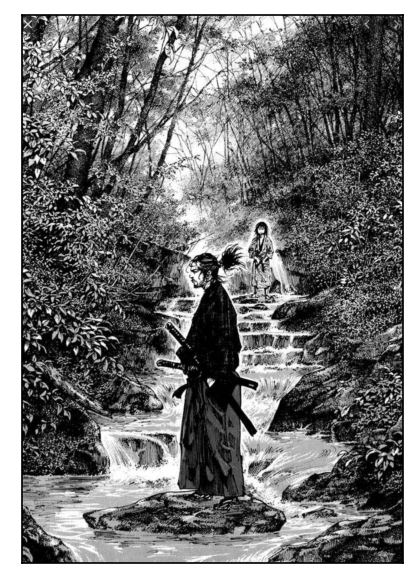

In [4]:
# Load image
im = Image.open('input/sample.jpg').convert('L')
im_arr = np.array(im)
print('Image size:', im_arr.shape)

# Preview
print('Preview:')
show_img(im_arr)
plt.show()

Compress image with $k=100$

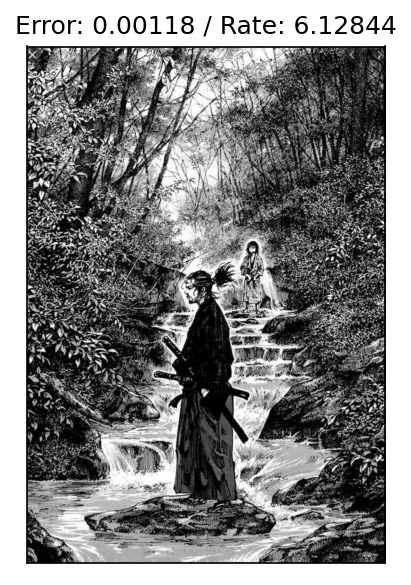

In [5]:
im_arr100, error100, r100 = compress_image(im_arr, 100)

show_img(im_arr100, f'Error: {error100:.5f} / Rate: {r100:.5f}')

Compress image with $k = 10, 20, 30, ..., 1000$

In [6]:
im_arrks = []
errorks = []
rks = []
for k in range(1, 101):
    im_arrk, errork, rk = compress_image(im_arr, 10*k)
    im_arrks.append(im_arrk)
    errorks.append(errork)
    rks.append(rk)

# Visualization

Save results

In [7]:
os.makedirs('output/sample/images', exist_ok=True)
for k, im_arrk in enumerate(im_arrks, 1):
    imk = Image.fromarray(im_arrk).convert('L')
    imk.save(f'output/sample/images/I{10*k}.jpg')

In [8]:
f = open('output/sample/rk.txt', 'w')
for k, rk in enumerate(rks, 1):
    f.write(f'k = {10*k:4d}: {rk:.9f}\n')
f.close()

Plot graphs for analysis

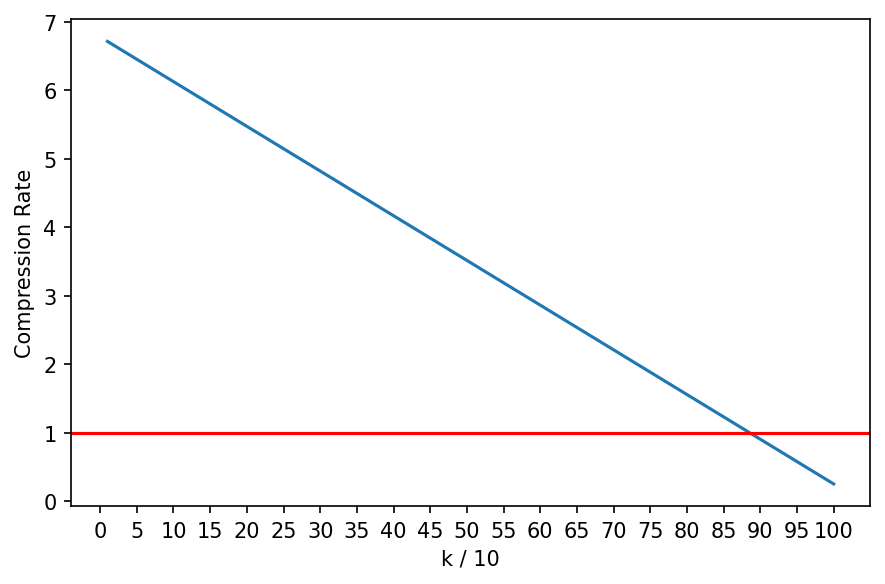

In [9]:
plt.plot(range(1, 101), rks)
plt.xticks(range(0, 101, 5))

plt.axhline(1, 0, 1, color='r')

plt.xlabel('k / 10')
plt.ylabel('Compression Rate')

plt.savefig('output/sample/compression-rate')

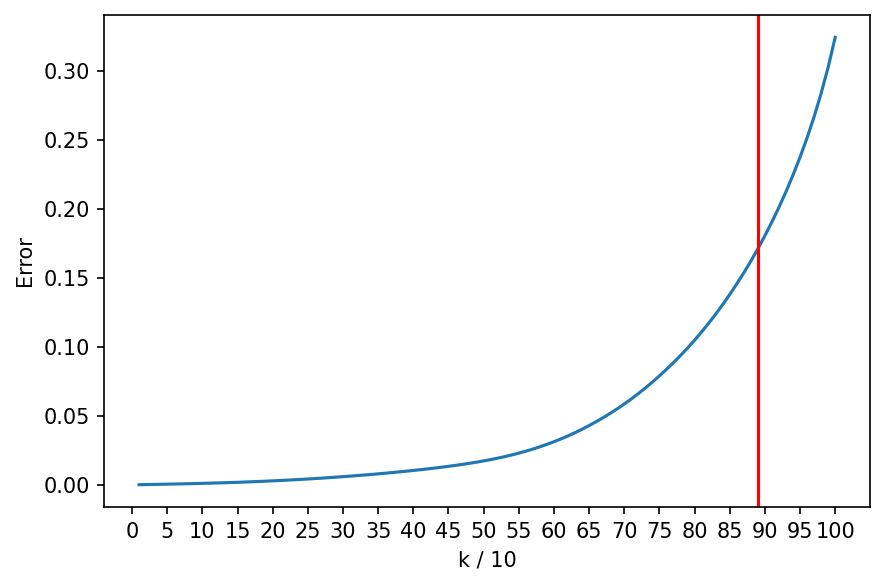

In [10]:
plt.plot(range(1, 101), errorks)
plt.xticks(range(0, 101, 5))
plt.axvline(89, 0, 1, color='r')

plt.xlabel('k / 10')
plt.ylabel('Error')

plt.savefig('output/sample/frobenius-error')